## To Do:
- apply trained net on 1200 and 1800 images on DECals
    - play w/ preprocessing 
    - check image and labels for training/val
- LASTRO 3-band

In [1]:
import sys
sys.path.append('..')
import time
from astropy.table import Table
import pyfits as fits
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser
from deeplens.resnet_classifier import deeplens_classifier
from deeplens.utils.blfchallenge import classify_ground_challenge 

from sklearn import metrics

home = expanduser("~")
import csv

Using Theano backend.


In [2]:
dir_path = home+'/Desktop/DECals_set/Train/'

In [4]:
let_index = np.load('lens_file_indicies.npy')

In [5]:
index = np.array([])
for i in let_index:
        index = np.concatenate((index,np.asarray((int(filter(str.isdigit, i)))).reshape(-1,)))
index = index.astype(int)

In [11]:
imgs = 323

ims = np.zeros((imgs, 3, 101, 101))

decalsA = 52
decalsB = 22
mzls = 7
groupdecals = 30
groupmzls = 12


# loads lens images 
for i, idx in enumerate(index):
    if i<decalsA:
        if i ==0:
            print 'loading grade A DECals lenses', i 
        ims[i] = fits.getdata('/Users/Chris/Desktop/DECals_set/Train/fits_images/lens_cutout_gradeA_{:06d}.fits'.format(idx))
    elif i>=decalsA and i<decalsA+decalsB:
        if i == decalsA:
            print 'switching to grade B DECals lenses', i
        ims[i] = fits.getdata('/Users/Chris/Desktop/DECals_set/Train/fits_images/lens_cutout_gradeB_{:06d}.fits'.format(idx))
    elif i>=decalsA+decalsB and i<decalsA+decalsB+mzls:
        if i == decalsA+decalsB:
            print 'switching to MzLS lenses', i
        ims[i] = fits.getdata('/Users/Chris/Desktop/DECals_set/Train/fits_images/lens_cutout_MzLS_{:06d}.fits'.format(idx))
    elif i>=decalsA+decalsB+mzls and i<decalsA+decalsB+mzls+groupdecals:
        if i == decalsA+decalsB+mzls:
            print 'switching to DECals group lenses', i
        ims[i] = fits.getdata('/Users/Chris/Desktop/DECals_set/Train/fits_images/lens_cutout_group_DECals_{:06d}.fits'.format(idx))
    elif i>=decalsA+decalsB+mzls+groupdecals:
        if i == decalsA+decalsB+mzls+groupdecals:
            print 'switching to MzLS group lenses', i
        ims[i] = fits.getdata('/Users/Chris/Desktop/DECals_set/Train/fits_images/lens_cutout_group_MzLS_{:06d}.fits'.format(idx))

loading grade A DECals lenses 0
switching to grade B DECals lenses 52
switching to MzLS lenses 74
switching to DECals group lenses 81
switching to MzLS group lenses 111


In [12]:
selected_ims = np.load(home+'/Desktop/DECals_set/selected_train_images.npy')
print selected_ims.shape

(200,)


In [13]:
for j in range(selected_ims.shape[0]):
    ims[j+decalsA+decalsB+mzls+groupdecals+groupmzls] = fits.getdata('/Users/Chris/Desktop/DECals_set/Non-Lenses/images/cutout_{:06d}.fits'.format(int(selected_ims[j])))

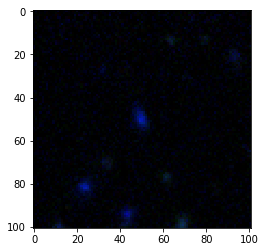

In [18]:
plt.imshow(ims[322].T*5)

In [80]:
ims = ims.ravel()

In [81]:
import copy
ims_copy = copy.copy(ims)

In [82]:
print 'max:',np.max(ims_copy)
print 'min:',np.min(ims_copy)
print 'mean:',np.mean(ims_copy)
print 'std:', np.std(ims_copy)

max: 102.838691711
min: -0.675041139126
mean: 0.0131096678328
std: 0.330793094313


In [83]:
ims_copy*=3
clip = 5

ims_copy = np.clip(ims_copy, -clip, clip)*20

print np.max(ims_copy)


100.0


max: 100.0
min: -40.5024683475
mean: 0.453639707929
std: 4.35583271591


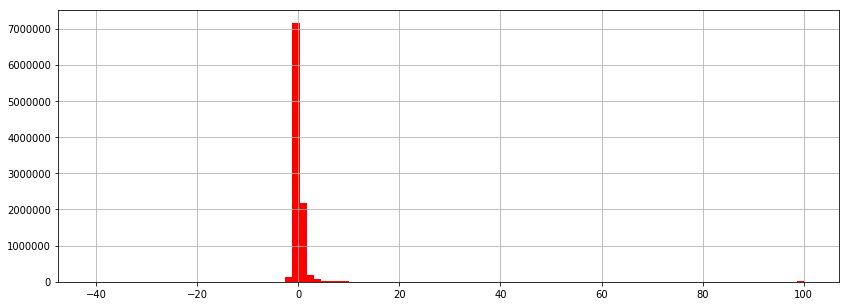

In [84]:
plt.figure(figsize= (14,5))
plt.hist(ims_copy, bins = 100, color = 'red', range = (np.min(ims_copy),np.max(ims_copy)))#, density = True)
# plt.xlim([90,100])
# plt.ylim([0,1000])
plt.grid(True)
print 'max:',np.max(ims_copy)
print 'min:',np.min(ims_copy)
print 'mean:',np.mean(ims_copy)
print 'std:', np.std(ims_copy)

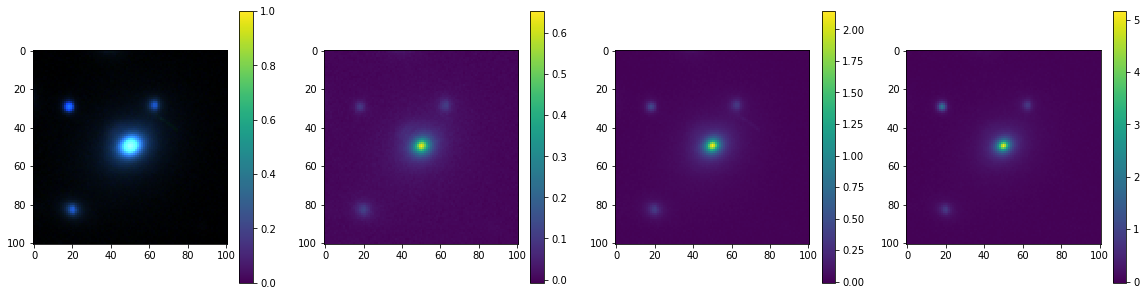

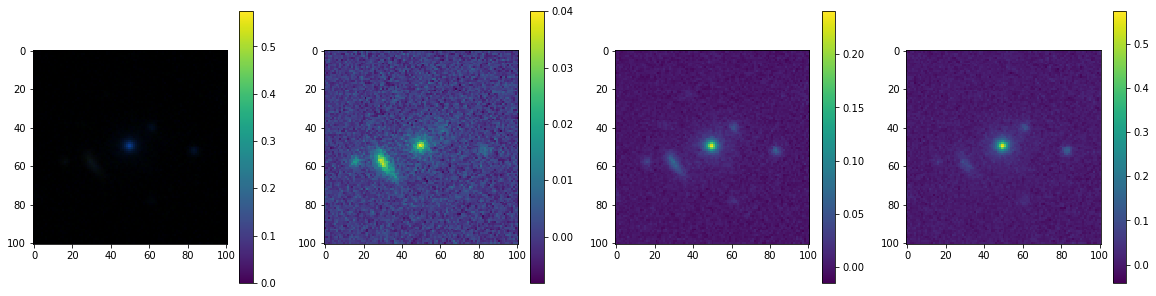

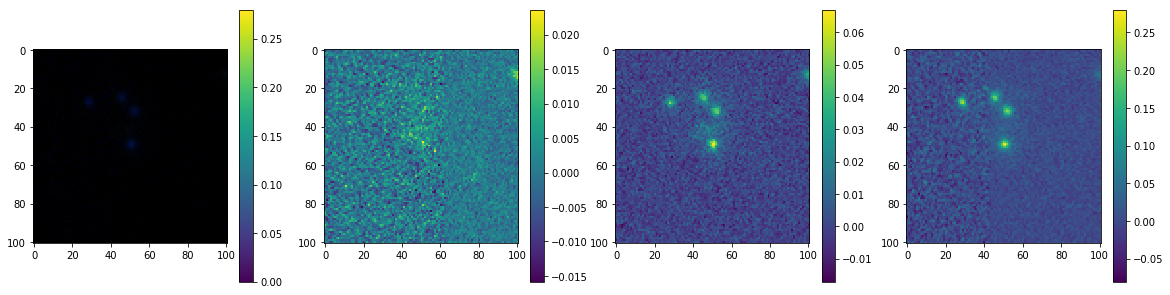

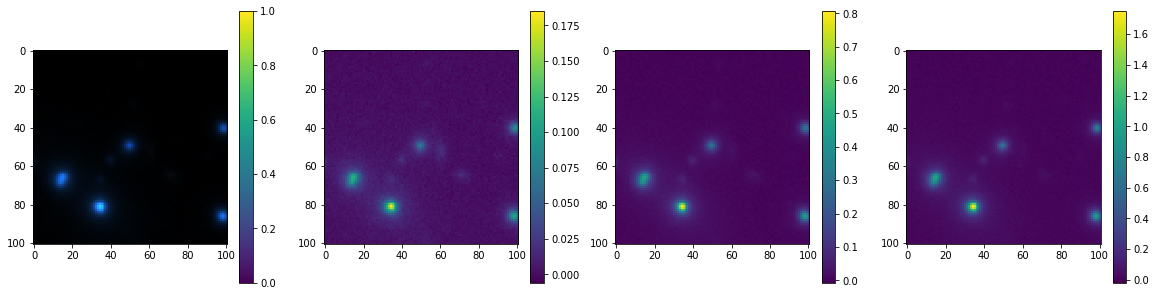

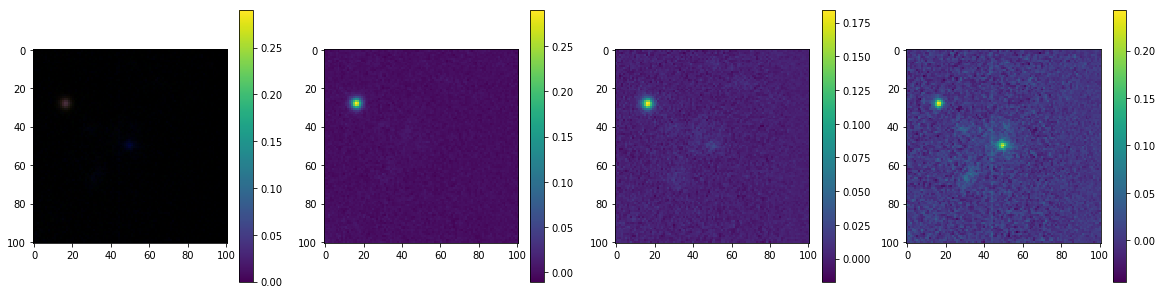

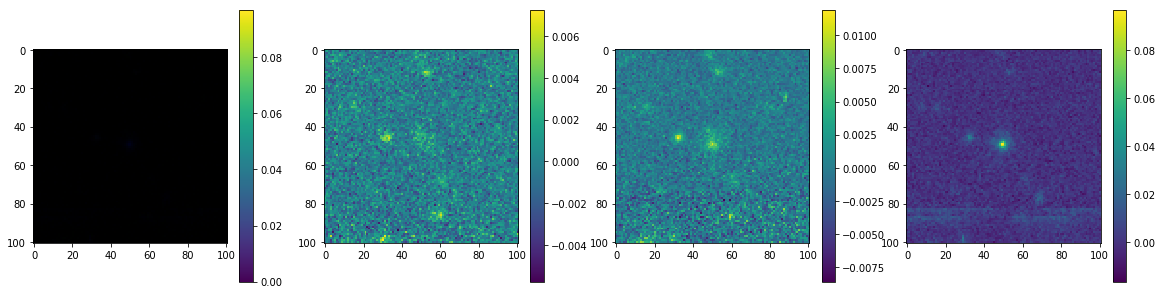

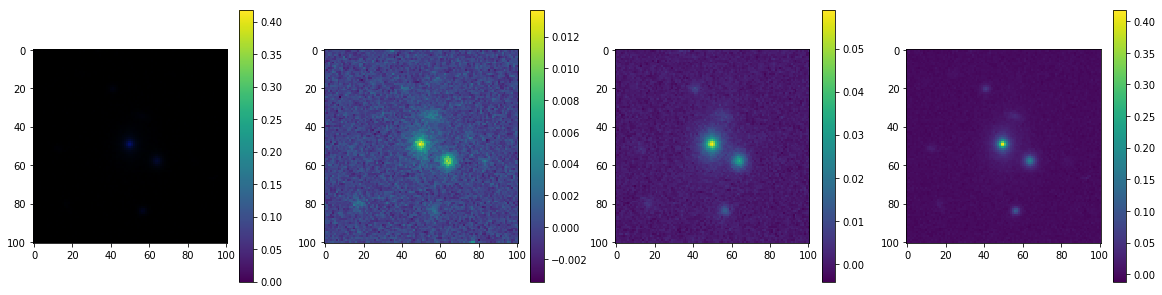

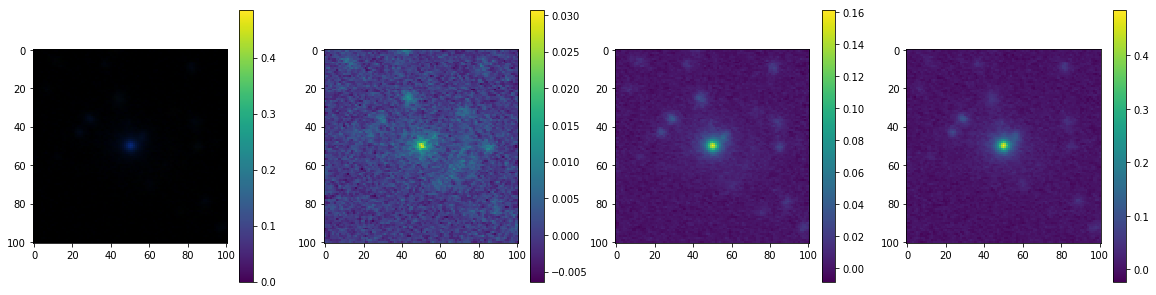

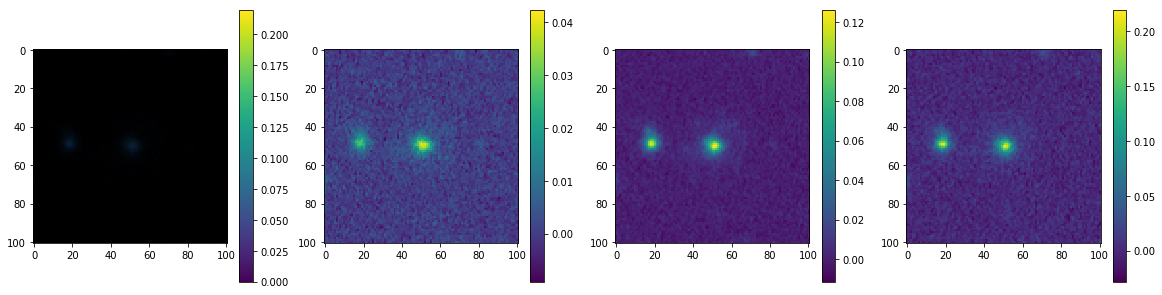

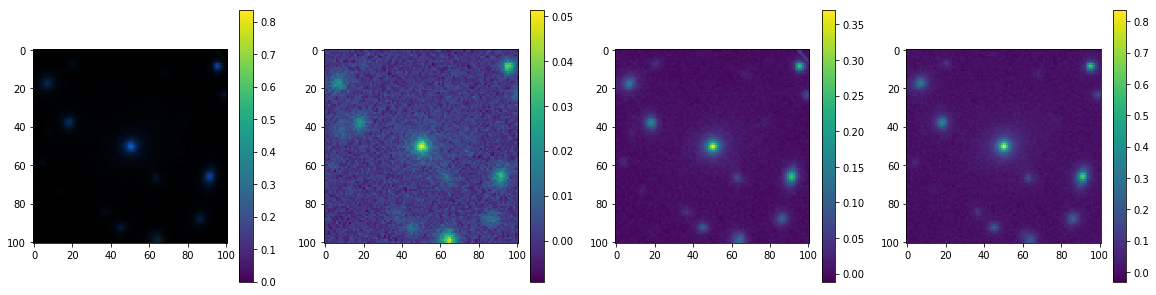

In [85]:
for prep, image in zip(ims.reshape(-1,3,101,101)[88:98], ims_copy.reshape(-1,3,101,101)[88:98]):
    plt.figure(figsize = (20,5))
    plt.subplot(141)
    plt.imshow(prep.T)
    plt.colorbar()
    plt.subplot(142)
    plt.imshow(prep[0].T)
    plt.colorbar()
    plt.subplot(143)
    plt.imshow(prep[1].T)
    plt.colorbar()
    plt.subplot(144)
    plt.imshow(prep[2].T)
    plt.colorbar()
    plt.show()

In [124]:
imgs = 240

download_path='//Volumes/CJSTORFER/' # To be adjusted on your machine

export_path=home+'/Desktop/'   # To be adjusted on your machine

d = Table.read(export_path+'catalogs_'+str(imgs)+'_RGB.hdf5', path='/ground')  

x = np.asarray(d['image']).reshape((-1,3,101,101))

In [125]:
x = x.ravel()

In [126]:
import copy
x_copy = copy.copy(x)

print 'max:',np.max(x_copy)
print 'min:',np.min(x_copy)
print 'mean:',np.mean(x_copy)
print 'std:', np.std(x_copy)

max: 100.0
min: -1.05758395097e-10
mean: 0.815810541453
std: 8.99530473667


In [127]:
vmin=-1e-9
vmax=1e-9
scale=100

mask = np.where(x == 100)


x_copy[mask] = 0

# Simple clipping and rescaling the images
x_copy = np.clip(x_copy, vmin, vmax)/vmax * scale

# x_copy-=np.mean(x_copy)

mask = np.where(x == 100)

x[mask] = 0


max: 100.0
min: -10.5758395097
mean: 0.23012201072
std: 2.28338524525


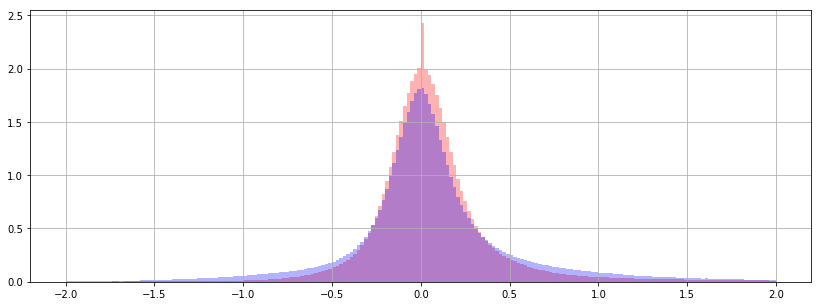

In [128]:
plt.figure(figsize= (14,5))
plt.hist(x_copy, bins = 200, color = 'red',alpha = 0.3, range = (-2,2),density = True)
plt.hist(ims_copy, bins = 200, color = 'blue',alpha = 0.3, range = (-2,2), density = True)
plt.grid(True)
print 'max:',np.max(x_copy)
print 'min:',np.min(x_copy)
print 'mean:',np.mean(x_copy)
print 'std:', np.std(x_copy)